<a href="https://colab.research.google.com/github/jamesluttringer2019/DS-Unit-2-Applied-Modeling/blob/master/module3/LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [33]:
pip install eli5

     |████████████████████████████████| 112kB 5.0MB/s 


In [2]:
pip install category_encoders

     |████████████████████████████████| 102kB 3.3MB/s 


In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
import re

In [0]:
df = pd.read_csv('https://github.com/jamesluttringer2019/unit2build/raw/master/trafficsample.csv', low_memory=False)

In [5]:
train, val = train_test_split(df, train_size=.8, test_size=.2, random_state=13)
train.shape, val.shape

((80000, 26), (20000, 26))

In [0]:
def wrangle(X):
  #avoid copy warning
  X = X.copy()

  #round times to nearest 5 minute interval
  times = []
  for i in X['stop_time']:
    i = str(i)  
    if i == 'nan':
      times.append(np.nan)
    else:
      if int(i[4]) < 3:
        i = (i[:4] + '0')
        times.append(i)
      elif int(i[4]) in (range(3,8)):
        i = (i[:4] + '5')
        times.append(i)
      else:
        i = (i[:3] + str(int(i[3])+1) + '0')
        times.append(i)
    
  X['stop_time'] = times

  #create individual columns for year, month, and day
  X['stop_date'] = pd.to_datetime(X['stop_date'])
  X['year'] = X['stop_date'].dt.year
  X['month'] = X['stop_date'].dt.month
  X['day'] = X['stop_date'].dt.day

  #Seperate vehicle make and year into their own columns
  make = []
  car_year = []
  for vehicle in X['vehicle_type']:
    make.append(re.search(r'^\w+|$', vehicle)[0])
    car_year.append(re.findall(r'\d+|$', vehicle)[0])

  X['vehicle_make'] = make
  X['vehicle_year'] = car_year

  #assume null for drugs_related_stop == false, replace values
  X['drugs_related_stop'].replace({np.nan:'False'}, inplace=True)

  #fill nulls in fine_grained_location
  X['fine_grained_location'].replace({np.nan:0}, inplace=True)

  #drop repetitive or unwanted columns
  drop_cols = ['id','state','location_raw', 'county_name',
             'county_fips','police_department','driver_race',
             'violation', 'district', 'search_type_raw',
             'stop_date', 'vehicle_type', 'is_arrested', 'search_type']
  X = X.drop(drop_cols, axis=1) 
  return X

In [0]:
train = wrangle(train)
val = wrangle(val)

In [0]:
#break into X matrices and y vectors
target = 'driver_gender'
features = train.columns.drop(target)

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

In [9]:
#get baseline f1_score
y_pred = ['M'] * len(y_val)
f1_score(y_val, y_pred, average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5889985113041443

In [10]:
X_train.head()

,stop_time,fine_grained_location,driver_age_raw,driver_age,driver_race_raw,violation_raw,search_conducted,contraband_found,stop_outcome,stop_duration,drugs_related_stop,year,month,day,vehicle_make,vehicle_year
61975,08:40,7,1947.0,61.0,Caucasian,"Moving Violation,Speed",False,False,Written Warning,15.0,False,2008,9,28,Toyo,1998
75905,21:15,10,1982.0,26.0,Caucasian,"Moving Violation,Speed",False,False,Written Warning,9.0,False,2008,4,21,Chev,2001
90174,00:20,17,1976.0,31.0,African American,"Moving Violation,Speed",False,False,Citation,14.0,False,2007,9,30,Linc,2003
60156,22:35,10,1990.0,24.0,Asian/Pacific Islander,"Equipment,Not applicable",False,False,Written Warning,7.0,False,2014,5,17,Kia,2004
62373,02:10,15,1986.0,20.0,African American,"Moving Violation,SeatBelt",False,False,Citation,NaN,False,2006,7,2,Satu,1994


In [0]:
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, random_state=13)
)

In [14]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['stop_time', 'fine_grained_location',
                                     'driver_race_raw', 'violation_raw',
                                     'stop_outcome', 'drugs_related_stop',
                                     'vehicle_make', 'vehicle_year'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                            

In [0]:
y_pred = pipeline.predict(X_val)

In [17]:
score = f1_score(y_val, y_pred, average='weighted')
print(f'Val F1 score: {score}')

Val F1 score: 0.6154212841993568


In [0]:
encoder = ce.OneHotEncoder()
X_train_enc = encoder.fit_transform(X_train)

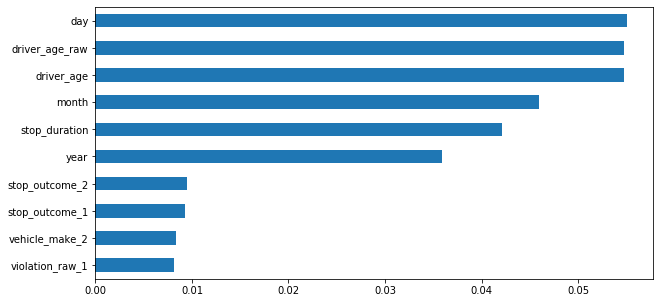

In [23]:
#see top 10 feature importances
rf = pipeline.named_steps['randomforestclassifier']
feat_importances = pd.Series(rf.feature_importances_, X_train_enc.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n=10
plt.figure(figsize=(10, n/2))
feat_importances.sort_values()[-n:].plot.barh();

In [0]:
#use XGBoost
from xgboost import XGBClassifier

In [0]:
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    XGBClassifier(n_estimators=100, random_state=13, n_jobs=-1)
)

In [26]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['stop_time', 'fine_grained_location',
                                     'driver_race_raw', 'violation_raw',
                                     'stop_outcome', 'drugs_related_stop',
                                     'vehicle_make', 'vehicle_year'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(bas...ster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,


In [28]:
y_pred = pipeline.predict(X_val)
score = f1_score(y_val,y_pred, average='weighted')
print(f'Val F1 score: {score}')

Val F1 score: 0.5897694776825945


In [31]:
X_val_enc = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators = 1000,
    max_depth = 5,
    learning_rate=.5,
    n_jobs = -1
)

eval_set = [(X_train_enc, y_train),
            (X_val_enc, y_val)]

model.fit(
    X_train_enc, y_train,
    eval_set = eval_set,
    eval_metric = 'error',
    early_stopping_rounds=50
)

[0]	validation_0-error:0.289075	validation_1-error:0.2907
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.289088	validation_1-error:0.2905
[2]	validation_0-error:0.28885	validation_1-error:0.29055
[3]	validation_0-error:0.288812	validation_1-error:0.2906
[4]	validation_0-error:0.28875	validation_1-error:0.2906
[5]	validation_0-error:0.288812	validation_1-error:0.2906
[6]	validation_0-error:0.288725	validation_1-error:0.2907
[7]	validation_0-error:0.2885	validation_1-error:0.29085
[8]	validation_0-error:0.288225	validation_1-error:0.2909
[9]	validation_0-error:0.2882	validation_1-error:0.29095
[10]	validation_0-error:0.287937	validation_1-error:0.29105
[11]	validation_0-error:0.287562	validation_1-error:0.2908
[12]	validation_0-error:0.287575	validation_1-error:0.2908
[13]	validation_0-error:0.28725	validation_1-error:0.29065
[14]	validation_0-error:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [34]:
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [0]:
transform = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(strategy='mean')
)

X_train_trans = transform.fit_transform(X_train)
X_val_trans = transform.transform(X_val)

In [39]:
model = RandomForestClassifier(n_estimators=100, random_state=13, n_jobs=-1)
model.fit(X_train_trans,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

In [0]:
permuter = PermutationImportance(
    model,
    scoring='f1_weighted',
    n_iter=5,
    random_state=13
)

permuter.fit(X_val_trans,y_val)

In [0]:
feature_names = X_val_enc.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

In [0]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)